# Bengali Hand-written Grapheme Classification

With FastAI
> Competition: https://www.kaggle.com/c/bengaliai-cv19


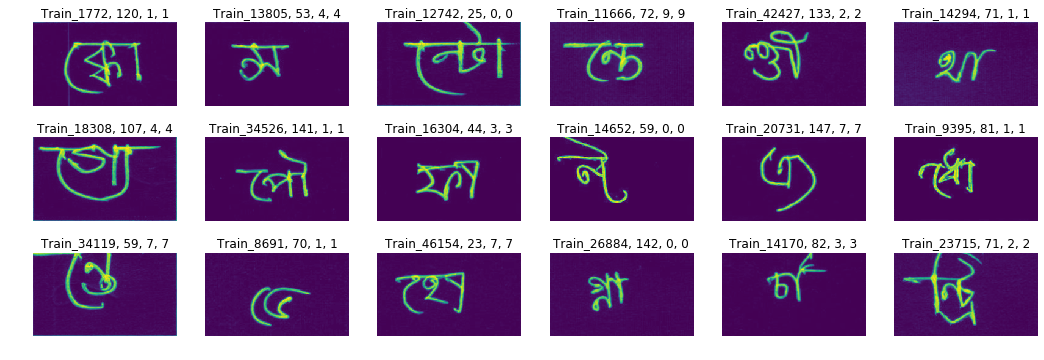

## Phase 1. Data loading and visualization

In [ ]:
from fastai.vision import *
import gc

Add [dataset in feather format](https://www.kaggle.com/corochann/bengaliaicv19feather)
to your kernel to load data faster than from original parquet files.

In [ ]:
datapath = Path("/kaggle/input/bengaliai-cv19/")
datapath_feather = Path("/kaggle/input/bengaliaicv19feather/")
modelspath = Path('/kaggle/input/pytorch-pretrained-image-models')

In [ ]:
def read_data(nf=1,pct=0.8):
    """Read a `nf` number of files and split with `pct` into `train_df` and valid_df`."""
    assert nf>=1 and nf<=4
    train_df   = pd.DataFrame()
    valid_df   = pd.DataFrame()

    for i in np.arange(nf):
        df_ = pd.read_feather(datapath_feather/f'train_image_data_{i}.feather')
        df_.drop('image_id',axis=1,inplace=True)
        msk = np.random.rand(len(df_)) < pct
        train_df = train_df.append(df_[msk],sort=False)
        valid_df = valid_df.append(df_[~msk],sort=False)
        del df_
        gc.collect()
    return train_df, valid_df

In [ ]:
train_df, valid_df = read_data(1,0.9)

In [ ]:
train_df.head()

In [ ]:
labels = pd.read_csv(datapath/'train.csv')
labels.head()

In [ ]:
train_lbls = labels.loc[train_df.index]
valid_lbls = labels.loc[valid_df.index]
assert len(train_lbls)+len(valid_lbls)==len(train_df)+len(valid_df)

In [ ]:
train_lbls[(train_lbls.vowel_diacritic==0) & (train_lbls.consonant_diacritic==0)]

In [ ]:
train_lbls.head()

In [ ]:
lbltfm

## Multilabel transformation

In [ ]:
class LblTfm():
    """Transform that encodes/decodes labels into/from one-hot vector, suitable for multi-class classification."""
    def __init__(self,mapfile):
        self.classmap = pd.read_csv(mapfile)
        self.file = mapfile
        self.c = len(self.classmap)
        self.cd_max,self.gr_max,self.vd_max = self.classmap.loc[:,['component_type','label']].groupby('component_type').count().label.values
    
    def __len__(self): 
        """Returns number of classes"""
        return self.c
    
    def __call__(self,gr,vd=None,cd=None):
        """Encodes `gr` and optional `vd`,`cd` into a one-hot array"""
        if gr is None and vd is None and cd is None: 
            print('Nones')
            return
        if gr is not None: assert (gr>=0 and gr<self.gr_max), f"Argument `gr` must be in range 0-{self.gr_max-1}"
        if vd is not None: assert (vd>=0 and vd<self.gr_max), f"Argument `vd` must be in range 0-{self.vd_max-1}"
        if cd is not None: assert (cd>=0 and cd<self.cd_max), f"Argument `cd` must be in range 0-{self.cd_max-1}"

        gr_,vd_,cd_ = None,self.gr_max,self.gr_max+self.vd_max       
        gr_,gr_char = gr, self.classmap.loc[0,'component'] #iloc[gr,(self.classmap.loc[:,'component_type']=='grapheme_root')&                         (self.classmap.loc[:,'label']==gr)].index.to_numpy().item()
        if vd is not None: vd_,vd_char = vd+168, self.classmap.loc[vd+168,'component']  #self.classmap[(self.classmap.loc[:,'component_type']=='vowel_diacritic')&    (self.classmap.loc[:,'label']==vd)].index.to_numpy().item()
        if cd is not None: cd_,cd_char = cd+179, self.classmap.loc[cd+179,'component']  #self.classmap[(self.classmap.loc[:,'component_type']=='consonant_diacritic')&(self.classmap.loc[:,'label']==cd)].index.to_numpy().item()
        return MultiCategory(one_hot((gr_,vd_,cd_),self.c),[gr,vd,cd],[gr_char,vd_char,cd_char])
        
    def decode(self,oh):
        """Decodes a one-hot array into `gr`,`vd`,`cd`"""
        assert len(oh) == self.c, f"Argument's len = {len(onehot)}, yet must equal to {self.c+1}"
        return oh[:self.gr_max].argmax(), oh[self.gr_max:self.gr_max+self.vd_max].argmax(), oh[self.gr_max+self.vd_max:].argmax()
    
    def __repr__(self):
        return f'Transformation based on `{self.file}\n'

In [ ]:
lbltfm = LblTfm(datapath/'class_map.csv')
lbltfm

In [ ]:
l = lbltfm(1,2,0)
l

`.data` stores one-hot array

In [ ]:
l.data

`.raw` stores characters of _grapheme root_, _vowel diacritic_ and _consonant diactitic_:

In [ ]:
l.raw

1. `.obj` stores codes (indexes) of _grapheme root_, _vowel diacritic_ and _consonant diactitic_:

In [ ]:
l.obj

In [ ]:
[print(l[1]) for l in train_lbls.iterrows()]

In [ ]:
y = train_lbls[:10]

In [ ]:
def lbl(o):
    """For iteration over DataFrame rows"""
    return lbltfm(o.grapheme_root,o.vowel_diacritic,o.consonant_diacritic)

In [ ]:
ls = y.apply(lbl,axis=1)

In [ ]:
MultiCategoryList(ls,classes=['root','vd','cd'],one_hot=True)

In [ ]:
ls[0],y.iloc[0]

In [ ]:
# Create a MultiCategory with:
# `data` corresponds to the one-hot encoded labels,
# `obj` that is a collection of labels, 
# `raw` is a list of associated string.
l = MultiCategory(ls[0],[15,9,5],None)

In [ ]:
l

In [ ]:
mcl=MultiCategoryList(ls,classes=['gr','vd','cd'],one_hot=True)

In [ ]:
mcl

## Dataset

In [ ]:
class BengaliDS(Dataset):
    """Customized dataset"""
    def __init__(self,x,y): #,transform=None):
        super().__init__()
        self.x,self.y = x,y
        self.c = 3
        #self.transform = transform

    def __len__(self):
        return len(self.x)
    
    # TODO: Add transforms, Categorized Labels
    def __getitem__(self,idx):
    #    if torch.is_tensor(idx):
    #        idx = idx.tolist()
        if isinstance(idx,int):
            return (torch.tensor(self.x.iloc[idx].values.astype(np.uint8).reshape(-1,137,236))/255.),\
                    self.y.iloc[idx].to_dict()
#         if self.transform is not None:
#             sample = self.transform(sample)
#        return x_,y_

In [ ]:
train_ds = BengaliDS(train_df,train_lbls)
valid_ds = BengaliDS(valid_df,valid_lbls)

In [ ]:
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True)
xb,yb = next(iter(train_dl))

In [ ]:
im = Image(xb[0])

In [ ]:
tfms = get_transforms()
tfms[0]

In [ ]:
im.apply_tfms(RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True))

In [ ]:
fig, axes = plt.subplots(3, 6, figsize=(18, 6))
axes = axes.flatten()
for i, ax in enumerate(axes):
    im = Image(xb[i])
    im.apply_tfms(RandTransform(tfm=TfmCrop(crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True))
    im.show(ax,cmap="viridis_r",title=yb['image_id'][i]+', '+str(yb['grapheme_root'][i].item())+', '+str(yb['vowel_diacritic'][i].item())+', '+str(yb['vowel_diacritic'][i].item()))

In [ ]:
valid_dl = DataLoader(valid_ds,batch_size=32,shuffle=False)

In [ ]:
dbunch = ImageDataBunch(train_dl,valid_dl)

In [ ]:
dbunch

In [ ]:
# model = torch.load(modelspath/'resnet34.pth')

In [ ]:
# model

In [ ]:
# learn = cnn_learner(dbunch,models.resnet34,pretrained=False)

In [ ]:
# import albumentations as A

In [ ]:
# !pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4/ > /dev/null # no output

In [ ]:
# import pretrainedmodels

In [ ]:
# model = pretrainedmodels.resnet34(pretrained=None)

In [ ]:
# learn.fit_one_cycle(1)

In [ ]:
lt = LblTfm(datapath)

In [ ]:
assert lt.decode(lt(167,1,5)) == (167,1,5)
assert lt(1).sum() == 3 # Empty vd and cd are nevertheless encoded as '1'
assert lt(167)[167] == 1
assert lt(0,0)[168] == 1
assert lt(0,cd=0)[168+11] == 1


In [ ]:
lt(0,vd=1)

In [ ]:
lt.decode(np.zeros(186))

In [ ]:
gr_root_cat = CategoryList(classmap[classmap.component_type=='grapheme_root'].label.values,      classmap[classmap.component_type=='grapheme_root'].component.values)
vd_cat      = CategoryList(classmap[classmap.component_type=='vowel_diacritic'].label.values,    classmap[classmap.component_type=='vowel_diacritic'].component.values)
cd_cat      = CategoryList(classmap[classmap.component_type=='consonant_diacritic'].label.values,classmap[classmap.component_type=='consonant_diacritic'].component.values)

In [ ]:
cd_cat

In [ ]:
train_lbls

In [ ]:
vd_cat

In [ ]:
cd_cat

In [ ]:
il = ItemLists(path='.',train=BengaliImageList(train_df),valid=BengaliImageList(valid_df))

In [ ]:
#from fastai.gen_doc.nbdoc import show_doc

In [ ]:
traindata = pd.read_csv(datapath/'train.csv')
traindata.head()

In [ ]:
traindata.grapheme_root.value_counts(sort=True).plot(kind='bar',title='grapheme_root values distribution\nin train set',figsize=(32,4));

In [ ]:
traindata.consonant_diacritic.value_counts(sort=False).plot(kind='bar',title='consonant_diacritic values distribution\nin train set');

In [ ]:
traindata.vowel_diacritic.value_counts(sort=False).plot(kind='bar',title='vowel_diacritic values distribution\nin train set');

In [ ]:
testdata = pd.read_csv(datapath/'test.csv')
testdata.head()

In [ ]:
class BengaliImageList(ImageList):
    def __init__(self,df:pd.core.frame.DataFrame):
        super().__init__(self)
        self.items = df
        self.ignore_empty = True
        
    def __len__(self):
        return len(self.items)
    
    def get(self,i:int):
        return Image(torch.tensor(train_df.iloc[i].values.astype(np.uint8).reshape(1,137,236)))
    #Image(torch.tensor(self.items.loc[i][1:].values).reshape(1,137,236))
    #    self.sizes[i] = sys.getsizeof(res)
    
    def __getitem__(self,idxs)->Any:
        "returns a single item based if `idxs` is an integer or a new `ItemList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, int): return self.get(idxs)
        else: return self.items.loc[idxs]#, inner_df=index_row(self.inner_df, idxs))
        
    def open(self, fn):
        pass

In [ ]:
tr_il = BengaliImageList(train_df)


In [ ]:
type(tr_il)

In [ ]:
# TODO: label_from_func expects BengaliImageList.items as iterable, not a DataFrame
type(tr_il.items)

In [ ]:
# data_src = (ImageItemList.from_df(df=df, path=parent_path, folder='train')
#             .label_from_df(cols=['class1','class2','class3','class4'], label_cls=MultiCategoryList, one_hot=True, classes=['class1','class2','class3','class4']))

In [ ]:
LabelList(tr_il,)

In [ ]:
tr_il[2]